In [1]:
import os
os.chdir('..') # this resolves ImportError: attempted relative import with no known parent package

# general DS packages
import pandas as pd
import numpy as np

# cleaning and pre-processing
from nltk.tokenize import RegexpTokenizer
from src.processing.text_cleaning import (normalize_text, process_contractions, remove_all_punctuation, remove_emojis, 
remove_html_unescape, remove_href_pattern, remove_digits, remove_extra_whitespace, remove_website_links)

from src.processing.text_processing import (tokenize_comment, lemmatize_comment, remove_stop_words, remove_tiny_tokens, 
remove_tekken_character_names_from_tokens, part_of_speech, part_of_speech_tag, part_of_speech_dependency, part_of_speech_shape, 
part_of_speech_alpha, part_of_speech_is_stop, word_count)

# modeling
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# visualisation
import matplotlib.pyplot as plt

# other
from operator import itemgetter

In [2]:
# import data from csv
raw_data = pd.read_csv("data/raw/new_character_reveal_comments.csv", )
data = raw_data.copy()
df = pd.DataFrame(data)

# Clean and process dataframe

In [3]:
%%time

# clean
df['textDisplay'] = df['textDisplay'].apply(normalize_text)
df['textDisplay'] = df['textDisplay'].apply(process_contractions)
df['textDisplay'] = df['textDisplay'].apply(remove_website_links)
df['textDisplay'] = df['textDisplay'].apply(remove_html_unescape)
df['textDisplay'] = df['textDisplay'].apply(remove_emojis)
df['textDisplay'] = df['textDisplay'].apply(remove_digits)
df['textDisplay'] = df['textDisplay'].apply(remove_all_punctuation)
df['textDisplay'] = df['textDisplay'].apply(remove_href_pattern)
df['textDisplay'] = df['textDisplay'].apply(remove_extra_whitespace)

# process
df["textDispalyWordCount"] = df['textDisplay'].apply(word_count)
df["textStopWordsRemoved"] = df["textDisplay"].apply(remove_stop_words)
df["textTokenized"] = df['textStopWordsRemoved'].apply(tokenize_comment)
df["textLemmatized"] = df["textStopWordsRemoved"].apply(lemmatize_comment)
# remove short meaningless tokens from lemmatized tokens
df["textLemmatized"] = df['textLemmatized'].apply(remove_tiny_tokens)
df["textTekkenCharactersRemoved"] = df["textLemmatized"].apply(remove_tekken_character_names_from_tokens)
df["textProcessedCharactersRemoved"] = df["textTekkenCharactersRemoved"].apply(lambda x: ' '.join(x))

# part of speech operations
df["pos"] = df["textStopWordsRemoved"].apply(part_of_speech)
df["posTag"] = df["textStopWordsRemoved"].apply(part_of_speech_tag)
df["posDependency"] = df["textStopWordsRemoved"].apply(part_of_speech_dependency)
df["posShape"] = df["textStopWordsRemoved"].apply(part_of_speech_shape)
df["posAlpha"] = df["textStopWordsRemoved"].apply(part_of_speech_alpha)
df["posStopWord"] = df["textStopWordsRemoved"].apply(part_of_speech_is_stop)


# remove rows with empty strings in the 'textProcessedCharactersRemoved' column as these will have nothing to pass to the vectorizer when we come to transforming the text input
# to numerical input
df = df[df["textProcessedCharactersRemoved"].astype(str) != '']
df.reset_index(drop=True, inplace=True)

df.head()

CPU times: user 39.4 s, sys: 46.7 ms, total: 39.4 s
Wall time: 39.5 s


,videoId,authorDisplayName,publishedAt,updatedAt,likeCount,totalReplyCount,textDisplay,textDispalyWordCount,textStopWordsRemoved,textTokenized,textLemmatized,textTekkenCharactersRemoved,textProcessedCharactersRemoved,pos,posTag,posDependency,posShape,posAlpha,posStopWord
0,rDxrpSqYHD8,@faizaanjaved7150,2023-11-01 16:10:05+00:00,2023-11-01 16:10:05+00:00,1,1,already seen it you are getting less views now...,10,seen getting views bamco,"[seen, getting, views, bamco]","[see, get, view, bamco]","[see, get, view, bamco]",see get view bamco,"[VERB, VERB, NOUN, NOUN]","[VBN, VBG, NNS, NNS]","[ROOT, xcomp, dobj, dobj]","[xxxx, xxxx, xxxx, xxxx]","[True, True, True, True]","[False, False, False, False]"
1,rDxrpSqYHD8,@TS-rw4lk,2023-11-01 16:10:05+00:00,2023-11-01 16:10:05+00:00,0,0,wow,1,wow,[wow],[wow],[wow],wow,[INTJ],[UH],[ROOT],[xxx],[True],[False]
2,rDxrpSqYHD8,@ALONCAK,2023-11-01 16:10:06+00:00,2023-11-01 16:10:06+00:00,0,0,oww yeaah,2,oww yeaah,"[oww, yeaah]","[oww, yeaah]","[oww, yeaah]",oww yeaah,"[PROPN, PROPN]","[NNP, NNP]","[compound, ROOT]","[xxx, xxxx]","[True, True]","[False, False]"
3,rDxrpSqYHD8,@Rough_Estimates,2023-11-01 16:10:06+00:00,2023-11-01 16:10:06+00:00,135,14,i hope we get an angel version of jin,9,hope angel version jin,"[hope, angel, version, jin]","[hope, angel, version, jin]","[hope, version]",hope version,"[PROPN, PROPN, PROPN, PROPN]","[NNP, NNP, NNP, NNP]","[compound, compound, compound, ROOT]","[xxxx, xxxx, xxxx, xxx]","[True, True, True, True]","[False, False, False, False]"
4,rDxrpSqYHD8,@kazamataurus337,2023-11-01 16:10:08+00:00,2023-11-01 16:10:08+00:00,1,0,so it begins,3,begins,[begins],[begin],[begin],begin,[VERB],[VBZ],[ROOT],[xxxx],[True],[False]


# NMF model
- At this point we have the text processed and avaibale in tokenized format and as a string
- We now need to turn the text into numbers
    - this can be done in a variety of ways e.g., TF-IDF, bag of words (which we previously used gensim to create as part of the LDA model)
    - We're going to use TF-IDF to create the features
- Once the features are created we can then create a topic model

### How NMF works
- Using the original input matrix (A) (and this input matrix is our text vectorized), NMF will give you two matrices (W and H).
- W is the topics it found and H is the coefficients (weights) for those topics.
- In other words, A is articles by words (original), H is articles by topics and W is topics by words.


So assuming 301 articles, 5000 words and 30 topics we would get the following 3 matrices:

        A = tfidf_vectorizer.transform(texts)
        W = nmf.components_
        H = nmf.transform(A)

        A = 301 x 5000
        W = 30 x 5000
        H = 301 x 30


- NMF will modify the initial values of W and H so that the product approaches A until either the approximation error converges or the max iterations are reached.
- In our case, the high-dimensional vectors are going to be tf-idf weights.

In [4]:
# turn the words into numbers
texts = df['textTekkenCharactersRemoved']

tfidf_vectorizer = TfidfVectorizer(
    min_df=3,  # ignore words that appear in less than x of the youtube comments
    max_df=0.85,   # ignore words that appear in more than x% of the comments
    max_features=999,   # each word will become a feature, set the max we want
    ngram_range=(1, 2),   # allow tf-idf weights for bigrams
    preprocessor=' '.join   # the model will tokenize everything by default so we need to join the tokenized words
)

In [5]:
# fit and transform the text input
tfidf = tfidf_vectorizer.fit_transform(texts)

## Create NMF model
- Manually set the number of topics to discover to 10; we'll use coherence score later to determine the best number of topics

In [6]:
# create and fit the NMF model
nmf = NMF(
    n_components=10,   # manually select number of topics
    init='nndsvd',   # ‘nndsvd’ initialiser works well on sparse data
    max_iter=100,
).fit(tfidf)

In [7]:
nmf

NMF(init='nndsvd', max_iter=100, n_components=10)

## scikit-learn to gensim to scikit-learn...
- scikit-learn's NMF implementations enables us to use TF-IDF, however scikit-learn's NMF model doesn't have a coherence score method.
- We need the coherence score to determine the optimum number of topics.
- So, we'll use gensim's Nmf and coherence score to get the optimum number of topics and then manually select this number of topics with scikit-learn's implementation so we can use TF-IDF instead of gensim's bag of words approach.

- **NOTE**: TF-IDF is superior to Bag of Words because:
 - Both are common ways of representing text representation in numerical format.
 - TF-IDF addresses the weaknesses of Bag of Words, namely TF-IDF:
   - de-emphasises common words and focusses on unique words
   - results in sparser feature vectors, with many zero values corresponding to irrelevant words. This can be beneficial for certain machine learning algorithms that perform better with sparse data, leading to improved model performance and interpretability.
   - the above helps overcome the word frequency bias that occurs with BoW which simply counts word occurrences, favoring frequent words regardless of their significance.

In [8]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['textTekkenCharactersRemoved']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_numbers = list(np.arange(5, 75+1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for number in topic_numbers:
    nmf = Nmf(
        corpus=corpus,
        num_topics=number,
        id2word=dictionary,
        chunksize=1000,   # number of documents to process at a time during model training, impacts memory usage and computational efficiency
        passes=5,   # number of complete passes over the corpus during training; more passes leads to better topic refinement but increases time
        kappa=.1,    # regularization parameter that controls model sparsity. Higher values encourage sparser topics, potentially leading to more distinct and interpretable results.
        minimum_probability=0.01,   # The minimum probability threshold for filtering out low-probability words from topics; helps focus on the most representative words for each topic.
        w_max_iter=300,   # The maximum number of iterations for updating the W (document-topic) and H (topic-word) matrices, respectively. 
                          # They control model convergence and can be adjusted based on model complexity and dataset size.
        w_stop_condition=0.0001,   # The convergence thresholds for W and H updates. Training stops when changes in these matrices fall below these thresholds.
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,   # Evaluate model perplexity on the corpus every eval_every iterations.
        normalize=True,   # Normalize document vectors before NMF factorization. It can improve convergence and topic quality in some cases.
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 3))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_numbers, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
best_num_topics

50

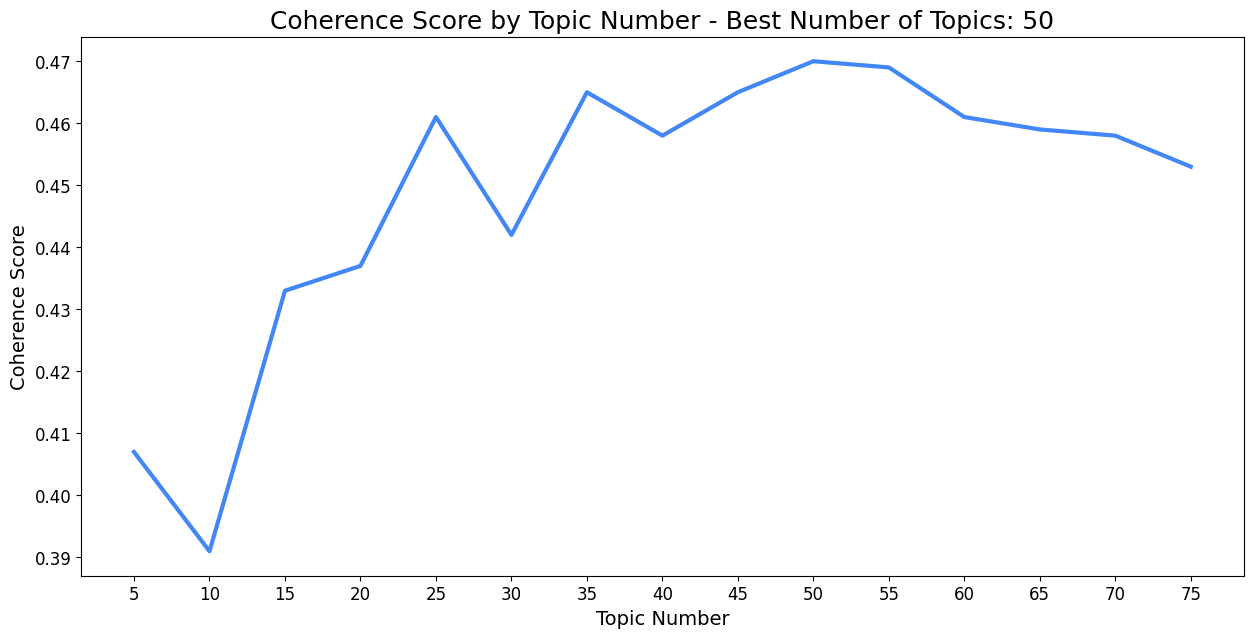

In [9]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_numbers,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Number", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_numbers) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## Number of topics
- 45 seems like a lot
- What's more important is the words making up these topics
- Trial and error and experimentation may find more optimal topic numbers

# Summarising topics
- Because this is unsupervised another challenge is summarizing the topics.
- One solution is to go through the texts and manually create topics, but this is laborious.
- Another option is to use the words in each topic that had the highest score for that topic and map these back to the feature names.
- Let'stry with the top 8 words.

## TODO - Make the below your own with your own cleaning functions and way of approaching this section
- Decide on number of topics - suggest 5, 10, 20
- Make the below code your own
- Tidy up entire notebook

In [10]:
# run the scikit-learn model with the optimal number of topics

texts = df['textTekkenCharactersRemoved']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=999,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)

In [11]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

In [13]:
# Use the top words for each cluster by tfidf weight to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

df_topic = topic_table(
    nmf,
    tfidf_feature_names,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
df_topic['topics'] = df_topic.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
df_topic['topics'] = df_topic['topics'].str[0]  # Removing the list brackets
df_topic['topics'] = df_topic['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
df_topic['topics'] = df_topic['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
df_topic['topics'] = df_topic['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
df_topic['topics'] = df_topic['topics'].str[0]  # Removing the list brackets

df_topic.head(15)

,0,1,2,3,4,5,6,7,topics
0,need,need bring,moveset,music,guest,need new,beg,wiliams,need bring moveset music guest new beg wiliams
1,bring,need bring,harada,crime,cmon,bring character,hope bring,queen,bring need harada crime cmon character hope queen
2,character,new character,guest,guest character,sad,bet,separate character,slot,character new guest sad bet separate slot
3,want,point,release,join,slim,people,badass,ancient,want point release join slim people badass anc...
4,hope,hope return,hope announce,announce,spot,fighter,hope get,amazing,hope return announce spot fighter get amazing


In [16]:
# Create a df with only the created topics and topic number
df_topic = df_topic['topics'].reset_index()
df_topic.columns = ['topic_num', 'topics']

df_topic

,topic_num,topics
0,0,need bring moveset music guest new beg wiliams
1,1,bring need harada crime cmon character hope queen
2,2,character new guest sad bet separate slot
3,3,want point release join slim people badass anc...
4,4,hope return announce spot fighter get amazing
5,5,wait not announce favorite join stay guess cha...
6,6,like look sound character dio thing story
7,7,come glad character story bad nov slim guy
8,8,trailer gameplay new individual ign reveal yos...
9,9,return hope legend make november right buy
